# Implementing scikitlearn estimators

In this notebook we implement scikit learn estimators to estimate the sparsity pattern in deepmod. Code has been modified already, we just need to build a new training loop.

In [1]:
import numpy as np
import pandas as pd
import torch

from DeePyMoD_SBL.data import Burgers
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss
from DeePyMoD_SBL.deepymod_torch.training import train
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

SyntaxError: non-default argument follows default argument (training.py, line 87)

# Making data

In [3]:
x = np.linspace(-2, 5, 75)
t = np.linspace(0.5, 5.0, 25)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [4]:
dataset = Burgers(0.1, 1.0)

In [5]:
u = dataset.solution(x_grid, t_grid)

In [6]:
X = np.concatenate((t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)), axis=1)
y = u.reshape(-1, 1)

In [7]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y, dtype=torch.float32, requires_grad=True)

In [8]:
noise_level = 0.05

In [9]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y + noise_level * np.std(y) * np.random.randn(y.size, 1), dtype=torch.float32, requires_grad=True)

# Finished run

Let's start by trying to one to run on a finished run:

In [125]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'fit_method':'lstsq'}

In [126]:
model = DeepModDynamic(**config)

In [127]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [128]:
train(model, X_train, y_train, optimizer, 5000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   1.22e-04   1.07e-04   1.49e-05   0.00e+00 

In [129]:
model.fit.coeff_vector

[tensor([[ 3.6146e-04],
         [-3.2395e-02],
         [ 9.4659e-02],
         [ 8.7055e-02],
         [-9.5481e-01],
         [-2.3779e-02],
         [-2.8188e-01],
         [ 2.0836e-01],
         [-2.2321e-02]], grad_fn=<MmBackward>)]

So that's already decent. Now let's build a function for the SKLearn estimator

In [130]:
from sklearn.linear_model import Lasso

In [131]:
regression_func = Lasso(alpha = 1e-4, fit_intercept=False, warm_start=True)

In [132]:
_, time_deriv_list, _, _, theta = model(X_train)

In [133]:
# Normalizing output
dt = (time_deriv_list[0] / torch.norm(time_deriv_list[0])).detach().cpu().numpy()
library = (theta / torch.norm(theta, dim=0, keepdim=True)).detach().cpu().numpy()

In [134]:
regression_func.fit(library, dt)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=True)

In [135]:
library

array([[ 2.3094011e-02, -7.6393841e-04, -1.7560687e-04, ...,
         4.1599151e-08, -5.0328308e-10, -5.7332559e-11],
       [ 2.3094011e-02, -7.4954121e-04, -1.6793852e-04, ...,
         4.9248911e-08, -5.8460387e-10, -6.4911604e-11],
       [ 2.3094011e-02, -7.5426686e-04, -1.3502689e-04, ...,
         2.2814547e-07, -2.7252502e-09, -2.4177285e-10],
       ...,
       [ 2.3094011e-02, -4.0604093e-04, -2.6956028e-05, ...,
         4.1664947e-07, -2.6792308e-09, -8.8145893e-11],
       [ 2.3094011e-02, -4.1904260e-04, -8.6138898e-05, ...,
         1.2691975e-06, -8.4228073e-09, -8.5803281e-10],
       [ 2.3094011e-02, -4.0795127e-04, -1.4998896e-04, ...,
         2.7227154e-06, -1.7590576e-08, -3.2050658e-09]], dtype=float32)

In [136]:
regression_func.coef_

array([ 0.        , -0.22397563,  0.2963842 , -0.        , -0.49769747,
        0.        , -0.        , -0.        ,  0.        ], dtype=float32)

In [137]:
torch.tensor(regression_func.coef_ != 0.0, dtype=torch.bool)

tensor([False,  True,  True, False,  True, False, False, False, False])

So that works. Let's set it up in a function

In [138]:
def determine_sparsity_mask(estimator, X, y):
    # Normalizing inputs
    y_normed = (y / torch.norm(y, keepdim=True)).detach().cpu().numpy()
    X_normed = (X / torch.norm(X, dim=0, keepdim=True)).detach().cpu().numpy()
    
    estimator.fit(X_normed, y_normed)
    sparsity_mask = torch.tensor(estimator.coef_ != 0.0, dtype=torch.bool)
    print(sparsity_mask)
    print(estimator.coef_)
    
    return sparsity_mask

In [139]:
determine_sparsity_mask(regression_func, theta, time_deriv_list[0])

tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.22393566  0.29639372 -0.         -0.49773443  0.
 -0.         -0.          0.        ]


tensor([False,  True,  True, False,  True, False, False, False, False])

In [140]:
model.fit.sparsity_mask

[tensor([True, True, True, True, True, True, True, True, True])]

In [141]:
def train_dynamic(model, data, target, optimizer, max_iterations, sparsity_estimator):
    '''Trains the deepmod model with MSE, regression and l1 cost function. Updates model in-place.'''
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms)

    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss_mse = mse_loss(prediction, target)
        loss = torch.sum(loss_reg) + torch.sum(loss_mse)
        
        # Writing
        if iteration % 100 == 0:
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_reg).item())
            board.write(iteration, loss, loss_mse, loss_reg, loss_reg, coeff_vector_list, coeff_vector_scaled_list)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Updating sparsity pattern
        if iteration % 200 == 0:
            with torch.no_grad():
                model.fit.sparsity_mask = [determine_sparsity_mask(sparsity_estimator, theta, time_deriv_list[0])]
               
         
    board.close()

In [142]:
lasso_estimator = Lasso(alpha = 1e-4, fit_intercept=False, warm_start=True)

In [143]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [144]:
train_dynamic(model, X_train, y_train, optimizer, 5000, lasso_estimator)

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
          0      0.00%               0s   1.22e-04   1.07e-04   1.49e-05   1.49e-05 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.22397563  0.2963842  -0.         -0.49769747  0.
 -0.         -0.          0.        ]
        200      4.00%              71s   1.53e-04   1.17e-04   3.62e-05   3.62e-05 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.19730565  0.32898834 -0.         -0.51572114  0.
 -0.         -0.          0.        ]
        400      8.00%              65s   1.24e-04   1.03e-04   2.02e-05   2.02e-05 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.16538101  0.33680338 -0.         -0.54595286  0.
 -0.         -0.          0.        ]
        600     12.00%              62s   1.06e-04   9.46e-05   1.18e-05   1.18e-05 tensor([False,  True,  True, False,  True, False, Fal

In [145]:
model.fit.sparsity_mask

[tensor([False,  True,  True, False,  True, False, False, False, False])]

In [146]:
model.fit.coeff_vector

[tensor([[ 0.0066],
         [ 0.1000],
         [-1.0248]], grad_fn=<MmBackward>)]

Fuck it works!!! Now let's try it out with other estimators

# Trying with lassocv

In [151]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'fit_method':'lstsq'}

In [152]:
model = DeepModDynamic(**config)

In [153]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [154]:
train(model, X_train, y_train, optimizer, 5000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   1.51e-04   1.23e-04   2.81e-05   0.00e+00 

In [155]:
from sklearn.linear_model import LassoCV

In [156]:
lassocv_estimator = LassoCV(fit_intercept=False)

In [157]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [172]:
train_dynamic(model, X_train, y_train, optimizer, 5000, lassocv_estimator)

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
          0      0.00%               0s   8.94e-05   8.86e-05   7.76e-07   7.76e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.5014791e-04 -0.0000000e+00  6.3563365e-01 -0.0000000e+00
 -9.0915442e-01  0.0000000e+00 -0.0000000e+00 -3.1983010e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


        200      4.00%              69s   8.94e-05   8.86e-05   7.57e-07   7.57e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 6.6405424e-04 -6.8539020e-04  6.3587934e-01 -0.0000000e+00
 -9.0669394e-01  0.0000000e+00 -0.0000000e+00 -3.4028254e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


        400      8.00%              64s   8.94e-05   8.86e-05   7.43e-07   7.43e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 6.8426324e-04 -0.0000000e+00  6.3582623e-01 -0.0000000e+00
 -9.0904284e-01  0.0000000e+00 -0.0000000e+00 -3.2114077e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


        600     12.00%              61s   8.94e-05   8.86e-05   7.30e-07   7.30e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 6.8914233e-04 -5.2387564e-04  6.3603657e-01 -0.0000000e+00
 -9.0735364e-01  0.0000000e+00 -0.0000000e+00 -3.3403166e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


        800     16.00%              59s   8.93e-05   8.86e-05   7.18e-07   7.18e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.0417614e-04 -0.0000000e+00  6.3599044e-01 -0.0000000e+00
 -9.0927500e-01  0.0000000e+00 -0.0000000e+00 -3.1759743e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       1000     20.00%              58s   8.93e-05   8.86e-05   7.08e-07   7.08e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 6.9916120e-04 -5.0486380e-04  6.3618147e-01 -0.0000000e+00
 -9.0766484e-01  0.0000000e+00 -0.0000000e+00 -3.2995597e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       1200     24.00%              53s   8.93e-05   8.86e-05   6.98e-07   6.98e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.1456598e-04 -0.0000000e+00  6.3611752e-01 -0.0000000e+00
 -9.0959859e-01  0.0000000e+00 -0.0000000e+00 -3.1327866e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       1400     28.00%              41s   8.93e-05   8.86e-05   6.89e-07   6.89e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.111455e-04 -4.799178e-04  6.363174e-01 -0.000000e+00 -9.079192e-01
  0.000000e+00 -0.000000e+00 -3.267166e-02  0.000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       1600     32.00%              47s   8.93e-05   8.86e-05   6.80e-07   6.80e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.2616356e-04 -0.0000000e+00  6.3623101e-01 -0.0000000e+00
 -9.0984601e-01  0.0000000e+00 -0.0000000e+00 -3.0988639e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       1800     36.00%              26s   8.93e-05   8.86e-05   6.73e-07   6.73e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.2241627e-04 -4.5828064e-04  6.3643974e-01 -0.0000000e+00
 -9.0812719e-01  0.0000000e+00 -0.0000000e+00 -3.2405019e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       2000     40.00%              29s   8.92e-05   8.86e-05   6.65e-07   6.65e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.3689187e-04 -0.0000000e+00  6.3633943e-01 -0.0000000e+00
 -9.0999234e-01  0.0000000e+00 -0.0000000e+00 -3.0760307e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       2200     44.00%              32s   8.92e-05   8.86e-05   6.58e-07   6.58e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.3280127e-04 -4.3534517e-04  6.3655317e-01 -0.0000000e+00
 -9.0830821e-01  0.0000000e+00 -0.0000000e+00 -3.2177199e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       2400     48.00%              35s   8.92e-05   8.86e-05   6.51e-07   6.51e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.4724056e-04 -0.0000000e+00  6.3643610e-01 -0.0000000e+00
 -9.1017413e-01  0.0000000e+00 -0.0000000e+00 -3.0508470e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       2600     52.00%               0s   8.92e-05   8.86e-05   6.45e-07   6.45e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.427804e-04 -4.141265e-04  6.366584e-01 -0.000000e+00 -9.084646e-01
  0.000000e+00 -0.000000e+00 -3.198110e-02  0.000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       2800     56.00%               0s   8.92e-05   8.86e-05   6.39e-07   6.39e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.5686985e-04 -0.0000000e+00  6.3652557e-01 -0.0000000e+00
 -9.1031992e-01  0.0000000e+00 -0.0000000e+00 -3.0299852e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       3000     60.00%               0s   8.92e-05   8.86e-05   6.34e-07   6.34e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.5245550e-04 -3.9471002e-04  6.3675463e-01 -0.0000000e+00
 -9.0860373e-01  0.0000000e+00 -0.0000000e+00 -3.1806715e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       3200     64.00%               0s   8.92e-05   8.86e-05   6.28e-07   6.28e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.6620991e-04 -0.0000000e+00  6.3660908e-01 -0.0000000e+00
 -9.1044915e-01  0.0000000e+00 -0.0000000e+00 -3.0113397e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       3400     68.00%               0s   8.92e-05   8.86e-05   6.24e-07   6.24e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.6129258e-04 -3.7499578e-04  6.3684362e-01 -0.0000000e+00
 -9.0873021e-01  0.0000000e+00 -0.0000000e+00 -3.1650100e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       3600     72.00%               0s   8.92e-05   8.86e-05   6.19e-07   6.19e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.7479047e-04 -0.0000000e+00  6.3668221e-01 -0.0000000e+00
 -9.1063404e-01  0.0000000e+00 -0.0000000e+00 -2.9878778e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       3800     76.00%               0s   8.92e-05   8.86e-05   6.14e-07   6.14e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.6991989e-04 -3.5673994e-04  6.3692915e-01 -0.0000000e+00
 -9.0884459e-01  0.0000000e+00 -0.0000000e+00 -3.1509288e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       4000     80.00%               0s   8.92e-05   8.85e-05   6.10e-07   6.10e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.8290037e-04 -0.0000000e+00  6.3675559e-01 -0.0000000e+00
 -9.1073143e-01  0.0000000e+00 -0.0000000e+00 -2.9732918e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       4200     84.00%               0s   8.92e-05   8.85e-05   6.06e-07   6.06e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.7776541e-04 -3.3790935e-04  6.3700765e-01 -0.0000000e+00
 -9.0895319e-01  0.0000000e+00 -0.0000000e+00 -3.1377602e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       4400     88.00%               0s   8.91e-05   8.85e-05   6.02e-07   6.02e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.8997185e-04 -0.0000000e+00  6.3682467e-01 -0.0000000e+00
 -9.1082132e-01  0.0000000e+00 -0.0000000e+00 -2.9597690e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       4600     92.00%               0s   8.91e-05   8.85e-05   5.98e-07   5.98e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.8526279e-04 -3.2264731e-04  6.3708234e-01 -0.0000000e+00
 -9.0904891e-01  0.0000000e+00 -0.0000000e+00 -3.1258725e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       4800     96.00%               0s   8.91e-05   8.85e-05   5.94e-07   5.94e-07 tensor([ True, False,  True, False,  True, False, False,  True, False])
[ 7.9741911e-04 -0.0000000e+00  6.3689041e-01 -0.0000000e+00
 -9.1089547e-01  0.0000000e+00 -0.0000000e+00 -2.9481208e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


       5000    100.00%               0s   8.91e-05   8.85e-05   5.92e-07   5.92e-07 tensor([ True,  True,  True, False,  True, False, False,  True, False])
[ 7.9238036e-04 -3.0624933e-04  6.3715351e-01 -0.0000000e+00
 -9.0914184e-01  0.0000000e+00 -0.0000000e+00 -3.1145869e-02
  0.0000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [173]:
model.fit.sparsity_mask

[tensor([ True,  True,  True, False,  True, False, False,  True, False])]

In [174]:
model.fit.coeff_vector

[tensor([[ 2.7573e-04],
         [ 1.0013e-01],
         [-9.8456e-01],
         [-4.7523e-02]], grad_fn=<MmBackward>)]

In [175]:
lassocv_estimator.coef_

array([ 7.9238036e-04, -3.0624933e-04,  6.3715351e-01, -0.0000000e+00,
       -9.0914184e-01,  0.0000000e+00, -0.0000000e+00, -3.1145869e-02,
        0.0000000e+00], dtype=float32)

In [176]:
lasso_estimator.alpha

0.0001

# LassoIC

In [177]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'fit_method':'lstsq'}

In [178]:
model = DeepModDynamic(**config)

In [179]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [180]:
train(model, X_train, y_train, optimizer, 5000, loss_func_args={'l1':0.0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   1.43e-04   1.19e-04   2.39e-05   0.00e+00 

In [181]:
from sklearn.linear_model import LassoLarsIC

In [182]:
lassocv_estimator = LassoLarsIC(fit_intercept=False)

In [183]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [184]:
train_dynamic(model, X_train, y_train, optimizer, 5000, lassocv_estimator)

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
          0      0.00%               0s   1.43e-04   1.19e-04   2.39e-05   2.39e-05 tensor([False,  True,  True,  True,  True,  True,  True,  True, False])
[ 0.         -0.05744649  0.64583517  0.13940497 -0.98215967 -0.25313371
 -0.27128633  0.15175832  0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


        200      4.00%              72s   1.37e-04   1.16e-04   2.12e-05   2.12e-05 tensor([False,  True,  True,  True,  True,  True,  True,  True, False])
[ 0.         -0.04500272  0.64442825  0.13008944 -0.98816544 -0.23819444
 -0.25358709  0.14095143  0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


        400      8.00%              65s   1.33e-04   1.14e-04   1.88e-05   1.88e-05 tensor([ True,  True,  True, False,  True, False,  True, False,  True])
[ 0.02032666 -0.09741139  0.57014385  0.         -0.8354018   0.
 -0.07655594  0.         -0.08623655]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


        600     12.00%              62s   1.30e-04   1.08e-04   2.22e-05   2.22e-05 tensor([ True,  True,  True, False,  True, False,  True, False,  True])
[ 0.01074484 -0.04965953  0.61725247  0.         -0.88652441  0.
 -0.04293027  0.         -0.09169713]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


        800     16.00%              59s   1.21e-04   1.03e-04   1.82e-05   1.82e-05 tensor([ True,  True,  True, False,  True, False,  True, False,  True])
[ 0.0100844  -0.03724614  0.61454301  0.         -0.89994747  0.
 -0.03887211  0.         -0.07328525]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       1000     20.00%              59s   1.15e-04   9.88e-05   1.57e-05   1.57e-05 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.04326479  0.55684596  0.         -0.87909654  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       1200     24.00%              53s   1.16e-04   9.96e-05   1.69e-05   1.69e-05 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.0140801   0.59193379  0.         -0.91291238  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       1400     28.00%              41s   1.08e-04   9.53e-05   1.29e-05   1.29e-05 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.00721592  0.59813732  0.         -0.92486822  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       1600     32.00%              47s   1.04e-04   9.39e-05   1.01e-05   1.01e-05 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.0044909   0.60687035  0.         -0.93004652  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       1800     36.00%              26s   1.01e-04   9.29e-05   8.50e-06   8.50e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.6166243   0.         -0.94061123  0.
 -0.00137719  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       2000     40.00%              29s   9.95e-05   9.22e-05   7.30e-06   7.30e-06 tensor([False,  True,  True, False,  True, False, False, False, False])
[ 0.         -0.0070965   0.60067815  0.         -0.91716135  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       2200     44.00%              32s   9.82e-05   9.17e-05   6.48e-06   6.48e-06 tensor([False, False,  True, False,  True, False, False, False, False])
[ 0.          0.          0.61663295  0.         -0.93578876  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       2400     48.00%              35s   9.72e-05   9.14e-05   5.75e-06   5.75e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.00000000e+00  0.00000000e+00  6.22597420e-01  0.00000000e+00
 -9.38885978e-01  0.00000000e+00 -5.07427729e-04  0.00000000e+00
  0.00000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       2600     52.00%               0s   9.63e-05   9.12e-05   5.13e-06   5.13e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.62189962  0.         -0.93844132  0.
 -0.00199079  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       2800     56.00%               0s   9.56e-05   9.09e-05   4.68e-06   4.68e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.6227455   0.         -0.93808149  0.
 -0.00187097  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       3000     60.00%               0s   9.50e-05   9.07e-05   4.29e-06   4.29e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.62377289  0.         -0.93787724  0.
 -0.00154787  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       3200     64.00%               0s   9.45e-05   9.06e-05   3.95e-06   3.95e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.62460742  0.         -0.93764994  0.
 -0.00137761  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       3400     68.00%               0s   9.41e-05   9.05e-05   3.66e-06   3.66e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.62534336  0.         -0.93744329  0.
 -0.00122129  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       3600     72.00%               0s   9.37e-05   9.03e-05   3.40e-06   3.40e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.62599361  0.         -0.93725848  0.
 -0.00108669  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       3800     76.00%               0s   9.34e-05   9.02e-05   3.16e-06   3.16e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.          0.          0.62657901  0.         -0.93709378  0.
 -0.00096968  0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       4000     80.00%               0s   9.31e-05   9.01e-05   2.94e-06   2.94e-06 tensor([False, False,  True, False,  True, False,  True, False, False])
[ 0.00000000e+00  0.00000000e+00  6.27110255e-01  0.00000000e+00
 -9.36946203e-01  0.00000000e+00 -8.68588423e-04  0.00000000e+00
  0.00000000e+00]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       4200     84.00%               0s   9.28e-05   9.00e-05   2.73e-06   2.73e-06 tensor([False, False,  True, False,  True, False, False, False, False])
[ 0.          0.          0.62530384  0.         -0.93415334  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       4400     88.00%               0s   9.25e-05   8.99e-05   2.55e-06   2.55e-06 tensor([False, False,  True, False,  True, False, False, False, False])
[ 0.          0.          0.62876502  0.         -0.93654846  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       4600     92.00%               0s   9.22e-05   8.99e-05   2.37e-06   2.37e-06 tensor([False, False,  True, False,  True, False, False, False, False])
[ 0.          0.          0.6291926   0.         -0.93657872  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       4800     96.00%               0s   9.20e-05   8.98e-05   2.22e-06   2.22e-06 tensor([False, False,  True, False,  True, False, False, False, False])
[ 0.          0.          0.6294845   0.         -0.93646081  0.
  0.          0.          0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


       5000    100.00%               0s   9.18e-05   8.97e-05   2.09e-06   2.09e-06 tensor([False, False,  True, False,  True, False, False, False, False])
[ 0.         0.         0.6297384  0.        -0.9363309  0.
  0.         0.         0.       ]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [187]:
lassocv_estimator.coef_

array([ 0.       ,  0.       ,  0.6297384,  0.       , -0.9363309,
        0.       ,  0.       ,  0.       ,  0.       ])

In [189]:
model.fit.coeff_vector

[tensor([[ 0.0997],
         [-1.0063]], grad_fn=<MmBackward>)]

# Testing code

In [2]:
import numpy as np
import pandas as pd
import torch

from DeePyMoD_SBL.data import Burgers
from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.training import train_dynamic
from sklearn.linear_model import LassoLarsIC

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2

# Making data

In [3]:
x = np.linspace(-2, 5, 75)
t = np.linspace(0.5, 5.0, 25)

x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [4]:
dataset = Burgers(0.1, 1.0)

In [5]:
u = dataset.solution(x_grid, t_grid)

In [6]:
X = np.concatenate((t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)), axis=1)
y = u.reshape(-1, 1)

In [7]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y, dtype=torch.float32, requires_grad=True)

In [26]:
y_train.shape

torch.Size([1875, 1])

In [27]:
noise_level = 0.2

In [28]:
X_train = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y + noise_level * np.std(y) * np.random.randn(y.size, 1), dtype=torch.float32, requires_grad=True)

# Testing normal

In [29]:
estimator = LassoLarsIC(fit_intercept=False)
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'sparsity_estimator': estimator}
model = DeepModDynamic(**config)
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)
train_dynamic(model, X_train, y_train, optimizer, 15000, loss_func_args={'sparsity_update_period': 200, 'start_sparsity_update': 5000})

In [30]:
config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 2}, 'sparsity_estimator': estimator}

In [33]:
model = DeepModDynamic(**config)

In [34]:
optimizer = torch.optim.Adam(model.network_parameters(), betas=(0.99, 0.999), amsgrad=True)

In [35]:
train_dynamic(model, X_train, y_train, optimizer, 15000, loss_func_args={'sparsity_update_period': 200, 'start_sparsity_update': 5000})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      15000    100.00%               0s   1.45e-03   1.44e-03   4.44e-06   0.00e+00 

In [36]:
model.sparsity_estimator.coef_

array([ 0.        , -0.01929325,  0.65838962,  0.        , -0.83905326,
        0.        ,  0.        , -0.08057578, -0.0435248 ])

In [38]:
model.constraints.coeff_vector

[tensor([[-0.0066],
         [ 0.1052],
         [-0.9272],
         [-0.1122],
         [-0.0114]], grad_fn=<MmBackward>)]

let's do another 5000, see if its better:

In [42]:
train_dynamic(model, X_train, y_train, optimizer, 5000, loss_func_args={'sparsity_update_period': 200, 'start_sparsity_update': 0})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       5000    100.00%               0s   1.45e-03   1.44e-03   3.98e-06   0.00e+00 

In [43]:
model.sparsity_estimator.coef_

array([ 0.        , -0.01982092,  0.65699666,  0.        , -0.83336538,
        0.        ,  0.        , -0.08681162, -0.0396705 ])

In [44]:
model.constraints.coeff_vector

[tensor([[-0.0073],
         [ 0.1049],
         [-0.9216],
         [-0.1220],
         [-0.0104]], grad_fn=<MmBackward>)]

# Analysing

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard(path):
    # Assumes one file per folder
    event_file = next(filter(lambda filename: filename[:6] =='events', os.listdir(path)))
    summary_iterator = EventAccumulator(str(path + event_file)).Reload()
    
    tags = summary_iterator.Tags()['scalars']
    steps = np.array([event.step for event in summary_iterator.Scalars(tags[0])])
    data = np.array([[event.value for event in summary_iterator.Scalars(tag)] for tag in tags]).T
    df = pd.DataFrame(data=data, index=steps, columns=tags)
    
    return df

In [20]:
df = load_tensorboard('runs/Apr20_09-11-22_4b6076e78386/')

In [21]:
df.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'scaled_coeff_0_0',
       'scaled_coeff_0_1', 'scaled_coeff_0_2', 'scaled_coeff_0_3',
       'scaled_coeff_0_4'],
      dtype='object')

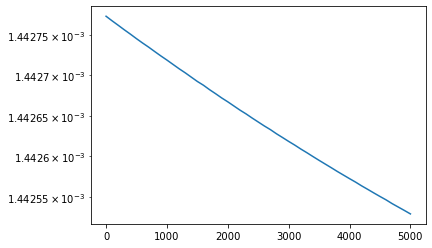

In [22]:
plt.semilogy(df['MSE_0'])

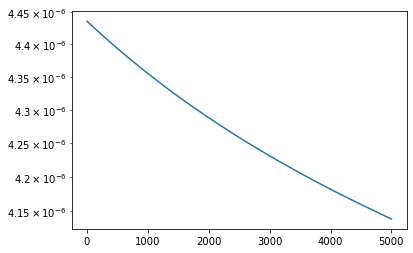

In [23]:
plt.semilogy(df['Regression_0'])

In [24]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']

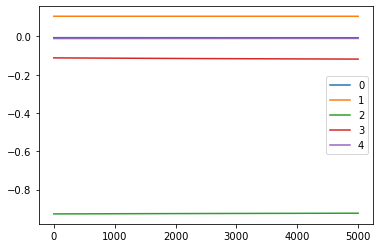

In [25]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()